In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ParseData
import scipy.stats as stats
import numpy as np
import pytablewriter
import matplotlib
import matplotlib.patches as mpatches
import importlib
importlib.reload(ParseData)

%matplotlib notebook

Data = ParseData.GetData()

plt.rc('axes', axisbelow=True)

DEATH CATEGORY
Off-Duty/Retired      7
Other               197
Shooting            434
Use of Force        134
Name: NAME FIRST, dtype: int64


<IPython.core.display.Javascript object>


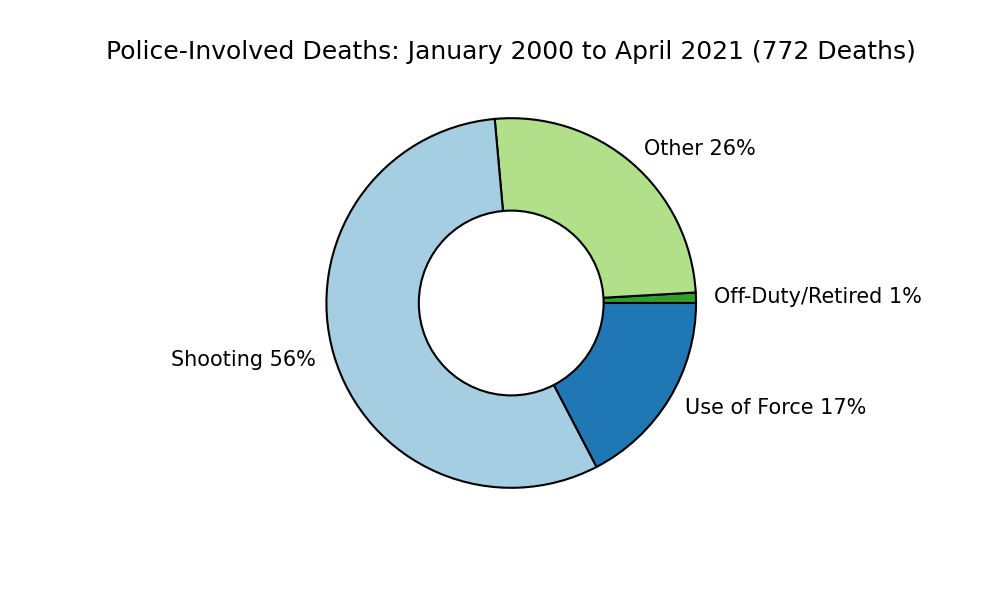

In [2]:
def Doughnut(Set,Colors,ax):
    names = []
    size = []
    colors = []
    if Colors == 'Random':
        for a,s in zip(Set.index.values,Set.values):
            names.append(a+' '+str(int(np.round(s/np.sum(Set.values)*100,0)))+'%')
            size.append(s)
            colors.append(np.random.rand(3))
    else:
        for a,s in zip(Set.index.values,Set.values):
            names.append(a+' '+str(int(np.round(s/np.sum(Set.values)*100,0)))+'%')
            size.append(s)
            colors.append(Colors[a])
    my_circle=plt.Circle( (0,0), 0.5, facecolor='white',edgecolor='k')
    ax.pie(size, labels=names, colors=colors,wedgeprops={"edgecolor":"k"})
    ax.add_artist(my_circle)

Color_Scheme = {'Shooting':'#a6cee3','Use of Force':'#1f78b4','Other':'#b2df8a',
            'Off-Duty/Retired':'#33a02c'}

Data.CA_PoliceKillings['DEATH CATEGORY'].fillna('Other')
Death_Cat=Data.CA_PoliceKillings.groupby('DEATH CATEGORY').count()['NAME FIRST']
# print(Data.CA_PoliceKillings.index.date.min())
# print()
print(Data.CA_PoliceKillings.groupby('DEATH CATEGORY').count()['NAME FIRST'])

fig,ax=plt.subplots(1,1,figsize = (6.65,4))
Doughnut(Death_Cat,Color_Scheme,ax)
ax.set_title('Police-Involved Deaths: January 2000 to April 2021 ('+str(Death_Cat.sum())+' Deaths)')

plt.savefig('Content/DeathsDistribution.png')

In [3]:
Death_Cats = (Data.CA_PoliceKillings.groupby(['DEATH CATEGORY','RACE'])['VICTIM ID'].count().unstack())
Death_Cats['Sum'] = Death_Cats.sum(axis=1) 
print(Death_Cats['Unknown']/Death_Cats['Sum'])


DEATH CATEGORY
Off-Duty/Retired    0.285714
Other               0.700508
Shooting            0.211982
Use of Force        0.425373
dtype: float64


In [4]:
Missing_During = (Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
                     (Data.CA_PoliceKillings.index<'2020-07-01'))].groupby('DEATH CATEGORY')['VICTIM ID'].count())
# print(Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
#                      (Data.CA_PoliceKillings.index<'2020-07-01')#&
# #                                  (Data.CA_PoliceKillings['DEATH CATEGORY']!='Use of Force')
#                                  ),'DEATH CATEGORY'])
print(Missing_During)
print(Missing_During.sum())

Missing_After = (Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
                     (Data.CA_PoliceKillings.index>='2020-07-01'))].groupby('DEATH CATEGORY')['VICTIM ID'].count())

print(Missing_After)
print(Missing_After.sum())

DEATH CATEGORY
Off-Duty/Retired      7
Other               129
Shooting              5
Use of Force         15
Name: VICTIM ID, dtype: int64
156
DEATH CATEGORY
Other           29
Shooting        23
Use of Force     8
Name: VICTIM ID, dtype: int64
60


Total Police Killings in Canada: January 1, 2000 - April 3, 2020: 772
74
Missing Recrods in CBC data:  156
Incidetns since CBC data published:  60
LinregressResult(slope=2.563636363636364, intercept=-5117.432900432901, rvalue=0.8492170001213043, pvalue=1.1242853026761138e-06, stderr=0.3657051460155805)


<IPython.core.display.Javascript object>


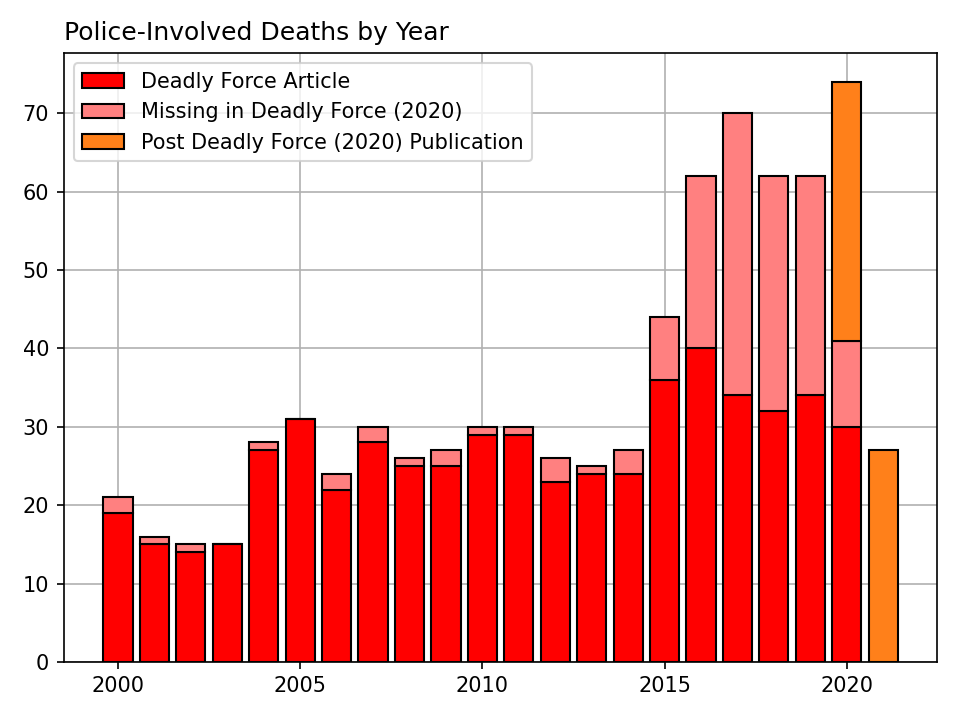

In [5]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: January 1, 2000 - April 3, 2020: '+str(CA_Total.sum()))
print(Data.CA_PoliceKillings.resample('YS').count()['PROV'].max())
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']

MonthlyMiss = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force'].resample('MS').count()['PROV']
print('Missing Recrods in CBC data: ',MonthlyMiss.loc[MonthlyMiss.index<'2020-07-01'].sum())

print('Incidetns since CBC data published: ',MonthlyMiss.loc[MonthlyMiss.index>='2020-07-01'].sum())


CBC_Article = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force')
#                                           &
#                                          (Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot')
                                         )
                                        ].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')
                                      &
                                         (Data.CA_PoliceKillings.index<='2020-07-01')
                                     )
                                    ].resample('YS').count()['PROV']
# print(Missing.resample('YS').count()['PROV'])

After = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings.index>='2020-07-01')
                                     )
                                    ].resample('YS').count()['PROV']
LR = stats.linregress(ByYear.index.year[:-1],ByYear.values[:-1])
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police-Involved Deaths by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = CBC_Article.values,#np.append(CBC_Article.values,[0]),
       color=[1,0.5,0.5],edgecolor='k',label='Missing in Deadly Force (2020)')
ax.bar(After.index.year,After.values,bottom = [CBC_Article.values[-1]+Missing.values[-1],0],#np.append(CBC_Article.values,[0]),
       color=[1,0.5,0.1],edgecolor='k',label='Post Deadly Force (2020) Publication')

plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

In [6]:
Category = 'RACE'
Departments=Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV',Category]).count()['VICTIM ID'].unstack()
Departments=Departments.reset_index().set_index('POLICE SERVICE')
Departments=Departments.fillna(value=0)
print(Departments.sort_values(by='Indigenous',ascending=False).head())

RACE                          PROV  Asian  Black  Indigenous  Latin American  \
POLICE SERVICE                                                                 
Winnipeg Police Service         MB    0.0    2.0        16.0             0.0   
RCMP                            BC    2.0    0.0        16.0             0.0   
RCMP                            AB    0.0    0.0        11.0             0.0   
RCMP                            NU    0.0    0.0        10.0             0.0   
Kativik Regional Police Force   QC    0.0    0.0         9.0             0.0   

RACE                           Middle Eastern  Other Visible Minority  \
POLICE SERVICE                                                          
Winnipeg Police Service                   1.0                     0.0   
RCMP                                      0.0                     0.0   
RCMP                                      0.0                     0.0   
RCMP                                      0.0                     0.0   
K

In [7]:
Departments['Total'] = Departments[Data.CA_PoliceKillings[Category].unique()].sum(axis=1)

Departments['NAME']=Departments.index
Departments['NAME']=Departments['NAME'].str.replace(' Department','')
Departments['NAME']=Departments['NAME'].str.replace(' Services','')
Departments['NAME']=Departments['NAME'].str.replace(' Service','')
Departments['NAME']=Departments['NAME'].str.replace(' Force','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de la Ville de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de la sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de ','')
Departments['NAME']=Departments['NAME'].str.replace('Régie intermunicipale de police ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Sécurité publique de ','')

Departments['City']=Departments['NAME'].str.replace('Ontario Provincial Police','')
Departments['City']=Departments['City'].str.replace(' Police','')
Departments['City']=Departments['City'].str.replace('RCMP','')
Departments['City']=Departments['City'].str.replace('Sûreté du Québec','')
Departments['City']=Departments['City'].str.replace(' Regional','')
Departments['City']=Departments['City'].str.replace('Royal Newfoundland Constabulary','')
Departments['City']=Departments['City'].str.replace(' Community','')
Departments['City']=Departments['City'].str.replace('South Coast British Columbia Transit Authority','')
Departments['City']=Departments['City'].str.replace("l'agglomération de ",'')
Departments['City']=Departments['City'].str.replace('du ','')

Departments['TYPE']='Municipal/Regional'
# Departments.loc[Departments.index.str.contains('Regional')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Toronto')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains("Service de police de l'agglomération de ")==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Transit Authority Police Service')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Régie intermunicipale de police')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Service de police de la Ville de Montréal')==True,'TYPE']='Regional'
Departments.loc[Departments.index.str.contains('RCMP')==True,'TYPE']='RCMP'
Departments.loc[Departments.index.str.contains('Ontario Provincial Police')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('OPP')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Sûreté du Québec')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Royal Newfoundland Constabulary')==True,'TYPE']='Provincial'

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "Deadliest Police Departments in Canada"
writer.header_list = ['Rank',"Department", "Province", "Killings"]
TB = Departments.loc[Departments['Total']>=10].sort_values(by='Total',ascending=False).reset_index()#[0:10]
writer.value_matrix = [[index+1,value['POLICE SERVICE'],value['PROV'],value['Total']]for index,value in TB.iterrows()]
# list(Departments.groupby('TYPE').count()['NAME'])
#     ["1", "AD", "Europe/Andorra"],
#     ["2", "AE", "Asia/Dubai"],
#     ["3", "AF", "Asia/Kabul"],
#     ["4", "AG", "America/Antigua"],
#     ["5", "AI", "America/Anguilla"],
# ]
# print(Departments.head())
writer.write_table()

print(Departments['Total'].count())
print(Departments.loc[Departments['Total']>=10,'Total'].sum())
print(Departments.loc[Departments['Total']>=10,'Total'].count())

print(Departments.loc[Departments['Total']>=10,'Total'].sum()/CA_Total.sum())

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total'])

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total']/CA_Total.sum())

# print(80/CA_Total.sum())


# Deadliest Police Departments in Canada
|Rank|                Department                |Province|Killings|
|---:|------------------------------------------|--------|-------:|
|   1|RCMP                                      |BC      |     102|
|   2|Toronto Police Service                    |ON      |      72|
|   3|Sûreté du Québec                          |QC      |      48|
|   4|Ontario Provincial Police                 |ON      |      48|
|   5|RCMP                                      |AB      |      47|
|   6|Service de police de la Ville de MontrÃ©al|QC      |      41|
|   7|Edmonton Police Service                   |AB      |      39|
|   8|Winnipeg Police Service                   |MB      |      32|
|   9|Calgary Police Service                    |AB      |      30|
|  10|Vancouver Police Department               |BC      |      27|
|  11|Peel Regional Police                      |ON      |      20|
|  12|Ottawa Police Service                     |ON      |      14|
|  13|R

In [8]:
# from geopy.geocoders import MapBox
# import geopandas as gpd
# api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

# geolocator = MapBox(api_key=api_key)

# # print(Departments)

# Departments['Lat']=np.nan
# Departments['Lon']=np.nan
# Departments['Geocoding_notes']=''

# for index,Service in Departments.sort_values(by='Total',ascending=False).iterrows():
#     try:
#         if Service.TYPE=='Municipal/Regional':
#             Point = geolocator.geocode(Service.NAME+', '+Service.City+', '+Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
#             Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
#         else:
#             Point = geolocator.geocode(Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
#             Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
#     except:
#         Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),'Geocoding_notes']='Geocoding Failed'
#         pass



# Departments_GPD = gpd.GeoDataFrame(Departments,
#     geometry=gpd.points_from_xy(Departments.Lon,
#                                 Departments.Lat
#                                ) )

# # Now we can assign a CRS
# WGS_1984={'init' :'epsg:4326'}
# Departments_GPD.crs = WGS_1984
# Departments_GPD = Departments_GPD.to_crs(Data.CA.crs)
# print('Done')

In [9]:
# print(Departments.loc[Departments['Geocoding_notes']=='Geocoding Failed'])

In [10]:
# # from geopy.geocoders import MapBox
# import folium
# # # from IPython.display import clear_output

# # api_key = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

# def plot_point(Map,X,Y,Popup_Text,Color='olive',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
#     folium.CircleMarker(
#         # The coordiatnates
#         location=[X,Y],
#         # Text description
#         popup=Popup_Text,
#         # sets the fill color for the point
#         fill_color=Color,
#         # Size of the marker
#         radius=Radius,
#         # Opacity of the circle
#         fill_opacity = Opacity,
#         # Sets the line color for the edge
#         color=LineColor,
#         # Width of the border line
#         line_weight=LineWidth,
#     ).add_to(Map)

# Scale,Offset=.5,1
    
# Final_Map = folium.Map(
#     location=[60,-91.5],
#     zoom_start=3,
#     tiles='Stamen Toner'
# )

# group0 = folium.FeatureGroup(name='RCMP')
# group1 = folium.FeatureGroup(name='Provincial Police Forces')
# group2 = folium.FeatureGroup(name='Municipal/Regional Police Forces')
# Cats=Data.CA_PoliceKillings['RACE'].unique()
# for index, row in Departments_GPD.iterrows():
#     if row['Geocoding_notes'] != 'Geocoding Failed':
        
#         # ''' indicates we're wrting multiline strings
#         # We'll write the header and the top row of the table
#         popuptext='''<body> <h2>'''+index+'''</h2> 
#                     <table style="width:100%">
#                     <tr>
#                     <th>Race</th>
#                     <th>Number of Killings &nbsp </th>
#                     <th>Percentage of Total</th>
#                     </tr>
#                      '''
        
#         # We'll sort each row by race so the largest appears at the top of the table
#         Sorted = row[Cats].sort_values(ascending=False)
#         for i,v in zip(Sorted.index,Sorted.values):
#             if (np.isnan(v)==False) and (v>0):
#                 if np.isnan(v)==False:
#                     # If the value for a race exists, we'll add it to the table
#                     popuptext+= '''<tr>
#                                 <td>'''+i+''' &nbsp </td>
#                                 <td>'''+str(int(v))+'''</td>
#                                 <td>'''+str(int(v/row['Total']*100))+'''%</td>
#                                 </tr>'''
#     #         We'll add row at the bottom of the table with the total


#         popuptext+='''<tr>
#                       <th>Total </th>
#                       <th>'''+str(row['Total'])+'''</th>
#                       <th> </th>
#                       </tr>'''
        
#         # We'll convert the text tot html
#         test = folium.Html(popuptext, script=True)
# #         folium.
        
#         # This defines the parameters for the popup text box
#         popup = folium.Popup(test, max_width=400,min_width=300)
        
# #         # Now we can send the popup to the CircleMarker
#         if row['TYPE']=='RCMP':
#             plot_point(Map=group0,
#                        X=row.Lat,#['latitude'],
#                        Y=row.Lon,#['longitude'],
#                        Popup_Text=popup,
#                        # This is hexcode for the official red of Canada
#                        Color='#FF0000',
#                        # We'll scale the radius by the number of killings + 2
#                        Radius=(row['Total'])*Scale+Offset,
#                       )
            
#         elif row['TYPE']=='Provincial':
#             plot_point(Map=group1,
#                        X=row.Lat,#['latitude'],
#                        Y=row.Lon,#['longitude'],
#                        Popup_Text=popup,
#                        # This is hexcode for the official red of Canada
#                        Color='#9400D3',
#                        # We'll scale the radius by the number of killings + 2
#                        Radius=(row['Total'])*Scale+Offset,
#                       )
#         else:
#             plot_point(Map=group2,
#                    X=row.Lat,#['latitude'],
#                    Y=row.Lon,#['longitude'],
#                    Popup_Text=popup,
#                    # This is hexcode for the official red of Canada
#                    Color='#0000ff',
#                    # We'll scale the radius by the number of killings + 2
#                    Radius=(row['Total'])*Scale+Offset,
#                   )
# group0.add_to(Final_Map)


# group2.add_to(Final_Map)


# group1.add_to(Final_Map)
    
# folium.LayerControl().add_to(Final_Map)
    
# Final_Map.save('Content/PoliceViolenceIncidents.html')
# Final_Map

VICTIM ID         289
DATE              289
NAME FIRST        289
NAME LAST         117
NAME MIDDLE        44
NICKNAME            3
AGE               232
GENDER            289
RACE              289
PROV              289
POLICE SERVICE    289
Second              2
Third               0
CAUSE DEATH       289
DEATH CATEGORY    289
ARMED TYPE        132
DATA SOURCE       289
Link              289
SUMMARY           131
Year              289
dtype: int64
0.034096332333932486
                               0
Black                    1198545
Asian                    2952065
Unknown                        0
Indigenous               1673780
White                   25803358
Other Visible Minority    364460
South Asian              1924640
Middle Eastern            787550
Latin American            447330


<IPython.core.display.Javascript object>


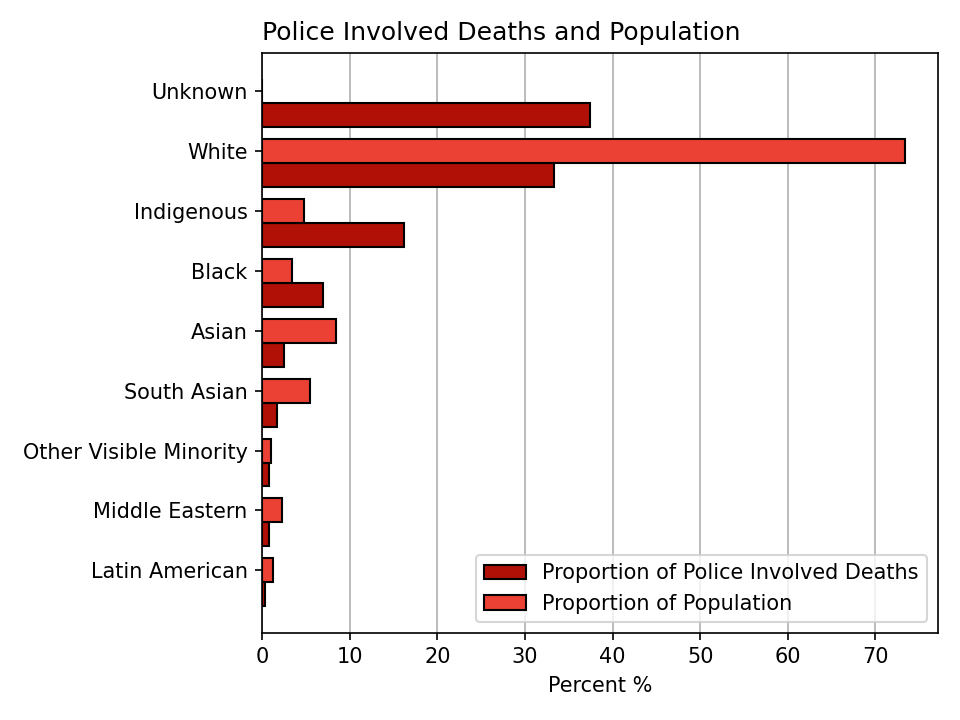

                            PROV         0
RACE                                      
Latin American          0.003886  0.012726
Middle Eastern          0.007772  0.022404
Other Visible Minority  0.007772  0.010368
South Asian             0.016839  0.054752
Asian                   0.024611  0.083981
Black                   0.069948  0.034096
Indigenous              0.161917  0.047616
White                   0.332902  0.734057
Unknown                 0.374352  0.000000


In [11]:
print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].count())
print(Data.CA.sum()['Black']/Data.CA.sum()['Total'])

Races = (Data.CA_PoliceKillings['RACE'].unique())
Pop = Data.CA[Races].sum().to_frame()
print(Pop)


fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Police Involved Deaths and Population',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=(ByRace/ByRace.sum()).to_frame()
ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values*100,color='#b01005',edgecolor='k',
        height=.4,label='Proportion of Police Involved Deaths',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values*100,color='#eb4034',edgecolor='k',
        height=.4,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Percent %')
ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Proportional.png')


In [12]:
# ByRace = (Data.CA_PoliceKillings.groupby('RACE').count()['PROV'])
# print(ByRace['Unknown']/ByRace.sum())
Temp = Data.CBC_Data_Original

print(Temp.count()['VICTIM ID'])
print(Temp.loc[Temp['RACE']=='Unknown'].count()['VICTIM ID'])
print(Temp.loc[Temp['NAME FIRST']=='Unknown'].count()['VICTIM ID'])
print(Temp.loc[Temp['CAUSE DEATH']=='Unknown'].count()['VICTIM ID'])
print()
All = Data.CA_PoliceKillings.copy()
print(All.count()['VICTIM ID'])
print(All.loc[All['RACE']=='Unknown'].count()['VICTIM ID'])

print(All.loc[All['RACE']=='Unknown'].count()['VICTIM ID']/All.count()['VICTIM ID'])
print(All.loc[All['NAME FIRST']=='Unknown'].count()['VICTIM ID'])
print(All.loc[All['CAUSE DEATH']=='Unknown'].count()['VICTIM ID'])

print(Temp.RACE.unique())

556
136
45
22

772
289
0.3743523316062176
187
75
['Other' 'Unknown' 'White' 'Black' 'Asian' 'Indigenous' 'South Asian'
 'Arab' 'Latin American' nan]


<IPython.core.display.Javascript object>


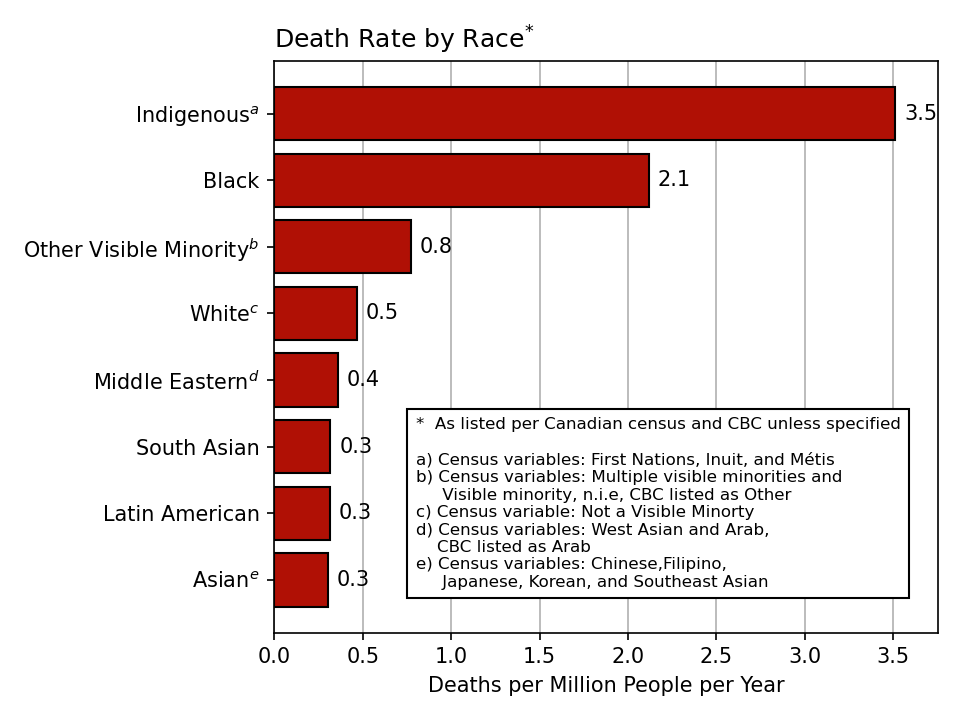

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                        PROV         0      Norm
RACE                                            
Asian                     19   2952065  0.302706
Latin American             3    447330  0.315418
South Asian               13   1924640  0.317678
Middle Eastern             6    787550  0.358316
White                    257  25803358  0.468435
Other Visible Minority     6    364460  0.774273
Black                     54   1198545  2.119006
Indigenous               125   1673780  3.512404
['Asian' 'Latin American' 'South Asian' 'Middle Eastern' 'White'
 'Other Visible Minority' 'Black' 'Indigenous']
1.0458064753432539
772


In [13]:

Annotated_lbl = ['Asian$^{e}$', 'Latin American', 'South Asian', 'Middle Eastern$^{d}$', 'White$^{c}$',
 'Other Visible Minority$^{b}$', 'Black', 'Indigenous$^{a}$']

fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Death Rate by Race$^{*}$',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=ByRace.to_frame()
ByRace = ByRace.join(Pop,lsuffix='_Pop')
ByRace['Norm']=ByRace['PROV'].values/ByRace[0].values*1e6/Data.CA_Length
ByRace=ByRace.sort_values(by='Norm')[:-1]
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
# ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values,color='#b01005',edgecolor='k',
#         height=.4,label='Proportion of Police Killings',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace['Norm'],color='#b01005',edgecolor='k',
        height=.8,label='Proportion of Population (2016)',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(Annotated_lbl)
print(ByRace.index.values)
ax.set_xlabel('Deaths per Million People per Year')
# ax.legend()

# $^{*}$
for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .4),verticalalignment='center')
ax.set_xlim(0,3.75)

ax.annotate('Cookies',(1,1))
ax.text(.8, -.1, '*  As listed per Canadian census and CBC unless specified\n\n'+
'a) Census variables: First Nations, Inuit, and Métis\n'+
'b) Census variables: Multiple visible minorities and \n'+
'     Visible minority, n.i.e, CBC listed as Other \n'+
'c) Census variable: Not a Visible Minorty\n'+
'd) Census variables: West Asian and Arab,\n'+
'    CBC listed as Arab\n'
'e) Census variables: Chinese,Filipino, '+
'\n     Japanese, Korean, and Southeast Asian',fontsize=8, bbox=dict(facecolor='White', alpha=1))

plt.tight_layout()

plt.savefig('Content/CA_Race_Normalized.png')


print(CA_Total.sum()/Data.CA.Total.sum()/21*1e6)
# print(Data.CA.Total.sum())
print(CA_Total.sum())

In [15]:
# # print(ByRace)
# from scipy.stats import chisquare
# # print(ByRace.index)
# # R = ['Indigenous','White','Black','Arab','Asian']

# R = ByRace.index.values#.drop('Unknown').values
# Dept = ['Winnipeg Police Service','Vancouver Police Department','Toronto Police Service','Calgary Police Service','Edmonton Police Service']
# City = ['Winnipeg','Vancouver','Toronto','Calgary','Edmonton']
# FOBS = []
# FEXP = []
# print(Data.Municipal_Boundaries['Name'].unique())
# # for D,C in zip(Dept,City):
# # #     print(D,C)
# #     F_obs = Departments_GPD.loc[Departments_GPD.index == D,R].values.flatten()
# #     F_exp = Data.Municipal_Boundaries.loc[Data.Municipal_Boundaries['Name'] == C,R].values.flatten()
# #     F_exp = F_exp/F_exp.sum()*Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']==D,'GENDER'].count()#F_obs.sum()
    
# #     FOBS.append(F_obs)
# #     FEXP.append(F_exp)
# # #     print(F_exp)
# #     res = chisquare(F_obs, f_exp=F_exp)
# #     print(C,F_obs.sum(),res[1])

# # print(Data.CA['PREABBR'])
# # print(Data.CA['PREABBR'])
# # Data.CA.head()
# P = Departments_GPD['PROV'].unique()
# # P2 = ['B.C.','B.C.']

# R2 = [r+'_Killings'for r in R]
# for p in P:
#     try:
#         F_obs = Data.CA.loc[((Data.CA.index ==  p)),
#                                     R2].fillna(0).values.flatten()
#         F_exp = Data.CA.loc[Data.CA.index== p,R].fillna(0).values.flatten()
#         F_exp = F_exp/F_exp.sum()*F_obs.sum()
#         FOBS.append(F_obs)
#         FEXP.append(F_exp)
# #         print(F_obs,F_exp)
#         res = chisquare(F_obs, f_exp=F_exp)
# #         print(p,F_obs.sum(),res[1])
        
#     except:
#         pass

# # print('UKN',Data.CA['Unknown_Killings'].sum())

# F_obs=Data.CA[R2].fillna(0).sum().values
# F_exp=Data.CA[R].fillna(0).sum().values

# F0 = F_exp.tolist()
# print(Data.CA_PoliceKillings.count())
# F0.append(F_exp.sum())
# F0.append(0)
# F_exp = F_exp*(Data.CA_PoliceKillings[Data.CA_PoliceKillings['RACE']!= 'Unknown'].count().RACE/F_exp.sum())

# print()
# res = chisquare(F_obs, f_exp=F_exp)
# print(res)
# R = R.tolist()
# R.append('Total (Excluding Unknown)')

# # R = np.append(R,'Unknown')

# F1 = F_exp.tolist()
# F1.append(F_exp.sum())
# # F1.append(0)
# F2 = F_obs.tolist()
# F2.append(Data.CA_PoliceKillings[Data.CA_PoliceKillings['RACE']!= 'Unknown'].count().RACE)
# # F2.append(Data.CA['Unknown_Killings'].sum())
# print('F2',F2)

# from tabulate import tabulate
# d = {"By Race": ["Total Population (Millions)", "Expected Distribtuion", "Observed Distribution"]}
# for i,r in enumerate(R):
#     d[r]=[int(F0[i]/1e5)/10,int(F1[i]),int(F2[i])]
# df = pd.DataFrame(d).set_index("By Race")
# df = df.T.sort_values(by='Total Population (Millions)',ascending=False).T
# # df.loc[df.index!='Observed Killings','Unknown']='--'


# print(tabulate(df.T, tablefmt="pipe", headers="keys"))


<IPython.core.display.Javascript object>


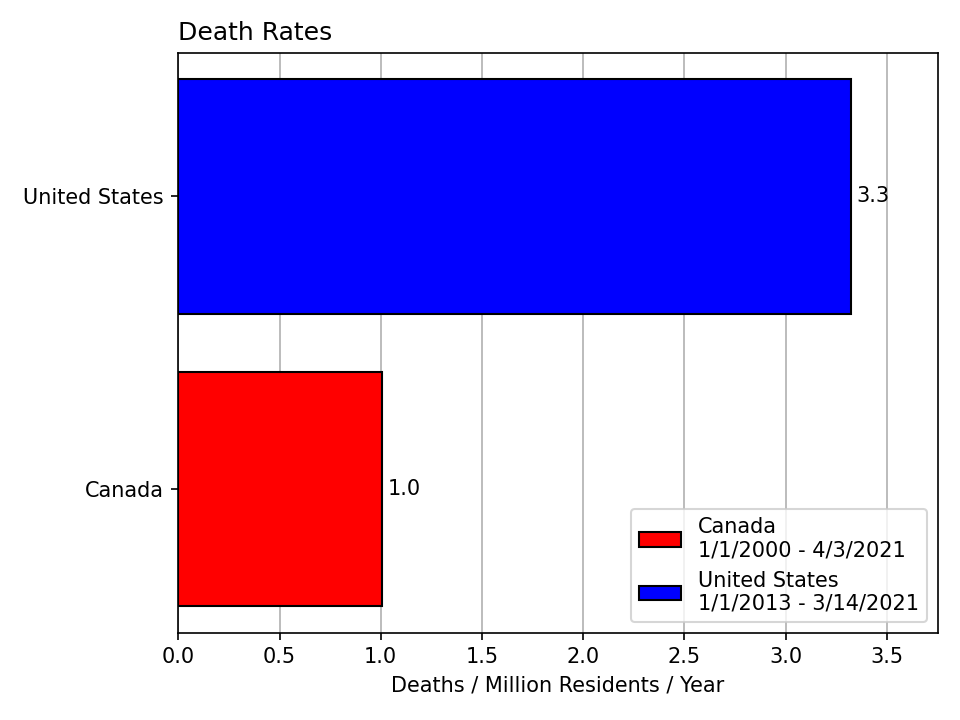

3.346965209677068 1.032912325199793 3.240318784103651


In [16]:
US_Total=Data.US_PoliceKillings["State"].count()
CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

fig,ax=plt.subplots()
ax.grid(axis='x')
ax.set_axisbelow(True)
# ax.grid(axis='x',zorder=0)
ax.barh([0],CA_Rate-.025,color=[1,0,0],edgecolor='k',label='Canada\n1/1/2000 - 4/3/2021')
ax.barh([1],US_Rate-.025,color=[0,0,1],edgecolor='k',label='United States\n1/1/2013 - 3/14/2021')
ax.text(CA_Rate,0,np.round(CA_Rate,1),horizontalalignment='left',verticalalignment='center')
ax.text(US_Rate,1,np.round(US_Rate,1),horizontalalignment='left',verticalalignment='center')
ax.set_yticks([0,1])
ax.set_yticklabels(['Canada','United States'])
ax.set_title('Death Rates',loc='left')
ax.set_xlabel('Deaths / Million Residents / Year')
ax.set_xlim(0,3.75)
ax.legend()


ax.legend()
plt.tight_layout()
plt.savefig('Content/NormalizedComparison.png')

print(US_Rate,CA_Rate,US_Rate/CA_Rate)

['Black' 'Asian' 'Unknown' 'Indigenous' 'White' 'Other Visible Minority'
 'South Asian' 'Middle Eastern' 'Latin American']
['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Other Visible Minority_Killings', 'Other Visible Minority_Rate', 'Other Visible Minority', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Middle Eastern_Killings', 'Middle Eastern_Rate', 'Middle Eastern', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Island

<IPython.core.display.Javascript object>


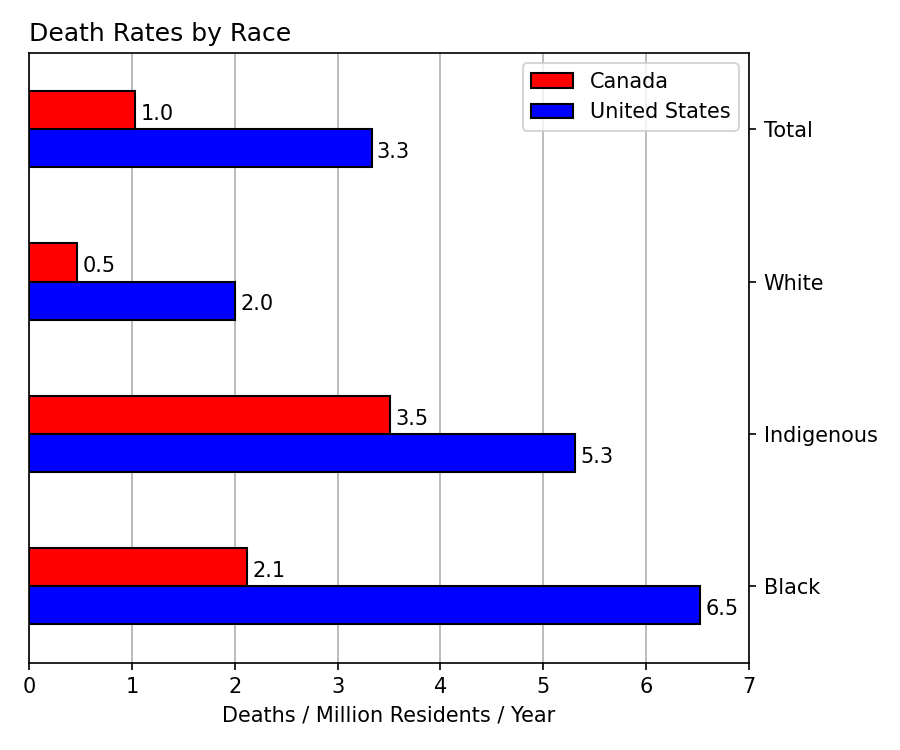

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
print(Data.CA_PoliceKillings['RACE'].unique())
# print(Data.Combined)

Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
# print(Data.Summary)
Data.Summary = Data.Summary.dropna()
Temp = Data.Summary.loc[((Data.Summary.index!='Asian'))]

fig,ax=plt.subplots(figsize=(6,5))
Temp['United States'] = Temp['US']
Temp['Canada'] = Temp['CA']
Temp[['United States','Canada']].plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder=2)
ax.set_title('Death Rates by Race',loc='left')
ax.set_xlabel('Deaths / Million Residents / Year')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .1),verticalalignment='center')

ax.set_xlim(0,7)
plt.tight_layout()
plt.savefig('Content/Racial_Comparison.png')


                  US        CA
Black       1.959811  2.051487
Indigenous  1.594882  3.400486
White       0.600761  0.453509


<IPython.core.display.Javascript object>


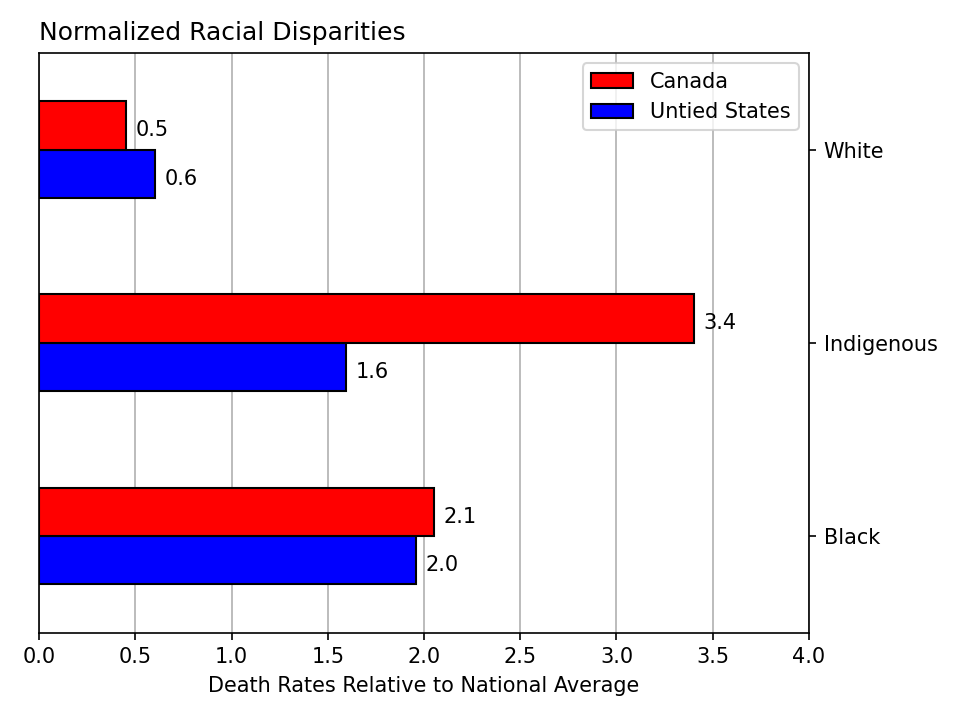

In [18]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='Total'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='Total'].values)
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='White']/Data.Summary.loc[Data.Summary.index=='Total'].values)

# Ratio *= 100
print(Ratio)
fig,ax=plt.subplots()
Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder = 2)
ax.set_title('Normalized Racial Disparities',loc='left')
ax.set_xlabel('Death Rates Relative to National Average')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['Canada','Untied States'])

for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .1),verticalalignment='center')

ax.set_xlim(0,4)
plt.tight_layout()
plt.savefig('Content/Racial_Disparities.png')


['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Other Visible Minority_Killings', 'Other Visible Minority_Rate', 'Other Visible Minority', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Middle Eastern_Killings', 'Middle Eastern_Rate', 'Middle Eastern', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


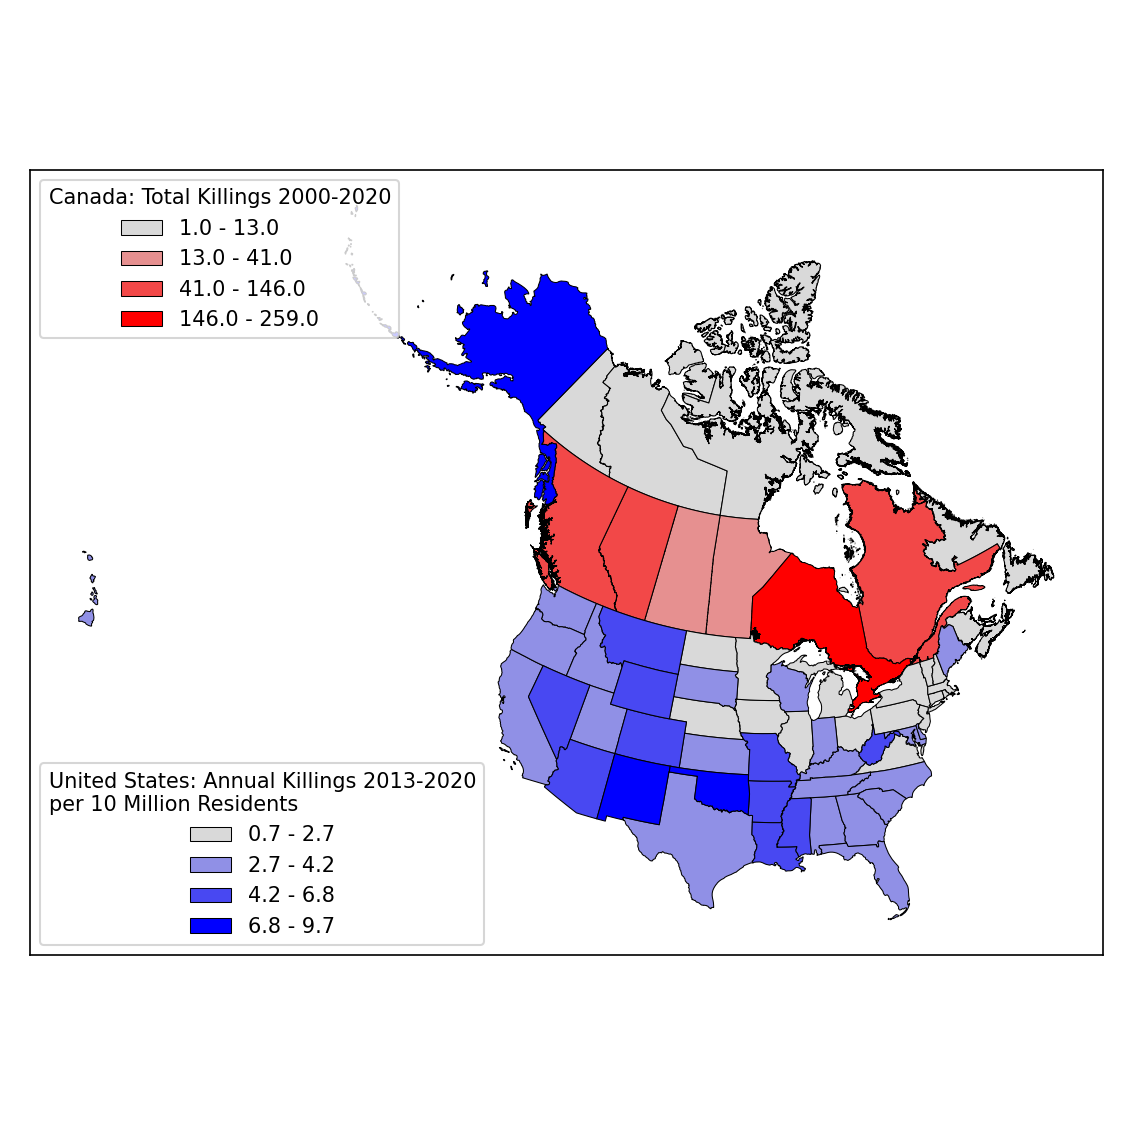

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Other Visible Minority_Killings', 'Other Visible Minority_Rate', 'Other Visible Minority', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Middle Eastern_Killings', 'Middle Eastern_Rate', 'Middle Eastern', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Legend does not support Text(0, 0, 'Canada') instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


In [19]:
Rate = 'Total'
n_classes=4

Data.ScaleData(scale=1e6)

Data.Breaks(column='Total_Killings',classes=n_classes,Manual_Bins=[1,4,7,91,175])
Data.US=Data.US.to_crs(Data.CA.crs)

labels=Data.CA[Rate+'_Killings_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = [matplotlib.text.Annotation('Canada',(0,0))]
for i,klass in enumerate(Data.CA[Rate+'_Killings_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
    if Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = []
# US_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canada: Total Killings 2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(US_Patches), loc='lower left',
      title='United States: Annual Killings 2013-2020\nper 10 Million Residents')
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title('Police Killings')

plt.tight_layout()
plt.savefig('Content/IsItNormalalized_Map.png',bbox_inches='tight')

In [26]:

Data.ScaleData(scale=1e6)
Rate='Total'
Data.Breaks(column=Rate+'_Rate',classes=5,Manual_Bins=[0,.5,1,1.5,2.5,15])

Data.US=Data.US.to_crs(Data.CA.crs)

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Other Visible Minority_Killings', 'Other Visible Minority_Rate', 'Other Visible Minority', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Middle Eastern_Killings', 'Middle Eastern_Rate', 'Middle Eastern', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


[(-0.001, 0.5], (0.5, 1.0], (1.0, 1.5], (1.5, 2.5], (2.5, 15.0]]
Categories (5, interval[float64]): [(-0.001, 0.5] < (0.5, 1.0] < (1.0, 1.5] < (1.5, 2.5] < (2.5, 15.0]]


<IPython.core.display.Javascript object>


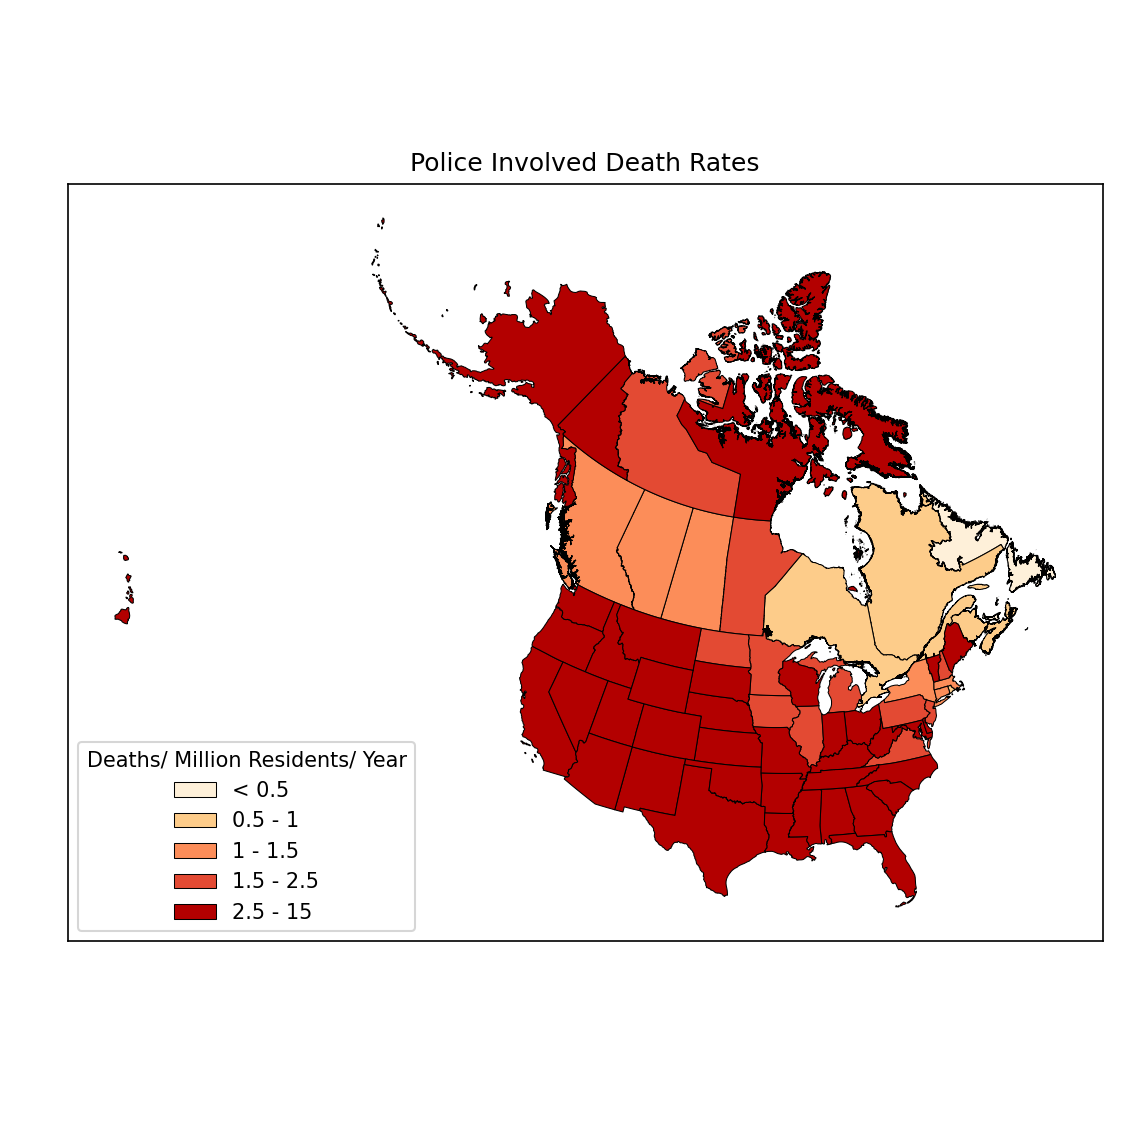

<IPython.core.display.Javascript object>


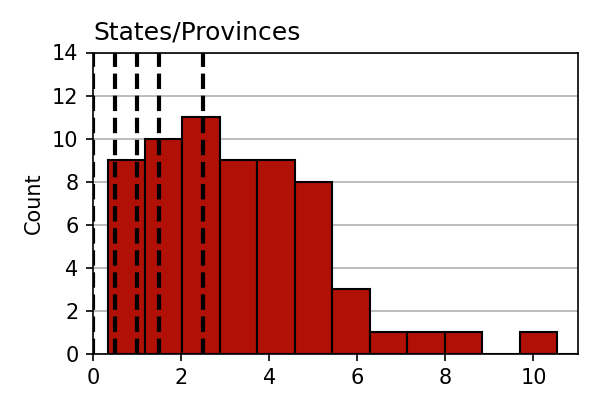

    Total_Rate  Total_Rate_MB
NL    0.361982  (-0.001, 0.5]
PE    0.329109  (-0.001, 0.5]
ON    0.905772     (0.5, 1.0]
QC    0.748883     (0.5, 1.0]
RI    0.692286     (0.5, 1.0]
..         ...            ...
AK    8.602333    (2.5, 15.0]
DE    2.901102    (2.5, 15.0]
MT    5.971625    (2.5, 15.0]
NE    2.655799    (2.5, 15.0]
TN    3.820190    (2.5, 15.0]

[64 rows x 2 columns]
[(-0.001, 0.5], (0.5, 1.0], (1.0, 1.5], (1.5, 2.5], (2.5, 15.0]]
Categories (5, interval[float64]): [(-0.001, 0.5] < (0.5, 1.0] < (1.0, 1.5] < (1.5, 2.5] < (2.5, 15.0]]


In [27]:

# Data.ScaleData(scale=1e6)
# Rate = 'Total'
# n_classes=4
# Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,1,2,5,10,15])


labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
print(labels)

colors=['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
Combined_Color = {key:value for key,value in zip(labels,colors)}
Combined_Color = {key:value for key,value in zip(labels,colors)}

ig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()

for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
#     print(i)
    if i == 5:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':'> '+str(np.round(Data.Manual_Bins[i],1))}
    elif i == 0:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':'< '+str(np.round(Data.Manual_Bins[i+1],1))}
    else:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
#     print(Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].index)
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
#     print(Combined_Patches)
ax.legend(handles=(Combined_Patches), loc='lower left',title='Deaths/ Million Residents/ Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Police Involved Death Rates')

plt.savefig('Content/ManualBreaks_Map.png',bbox_inches='tight',dpi=500)

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in Data.Manual_Bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/ManualBreaks_Hist.png')

print(Data.Combined[[Rate+'_Rate',Rate+'_Rate_MB']].sort_values(by=Rate+'_Rate_MB'))
print(Data.Combined[Rate+'_Rate_MB'].unique().sort_values())

In [22]:
print(Data.CA.Total_Rate.sort_values())

prov
PE     0.329109
NL     0.361982
NB     0.503621
NS     0.661993
QC     0.748883
ON     0.905772
SK     1.241793
AB     1.445473
BC     1.477320
MB     1.508418
NT     2.251086
YT     5.244125
NU    13.084780
Name: Total_Rate, dtype: float64


In [23]:
All = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().T
Data.CA['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.CA.loc[Data.CA.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.CA['Top'])


All = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().T
Data.US['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.US.loc[Data.US.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.US['Top'])


R = ['White','Black','Indigenous','Latin American','Hispanic','Pacific Islander']
Tempp = Data.Combined.copy()
for r in R:
    Tempp.loc[((Tempp[r]/Tempp['Total']<=.025)&(Tempp[r+'_Killings']<=2)),r+'_Rate']=np.nan
#     Tempp.loc[Tempp[r]<=5e3,r+'_Rate']=np.nan

Max = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']].max(axis=1)
Temp = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']]
# print(Temp.loc[Temp==Max])
Data.Combined['Top']=''
for index,row in Temp.iterrows():
#     print()
    Data.Combined.loc[Data.Combined.index==index,'Top']=row.loc[row==Max[index]].index.values[0].split('_')[0]
# print(Max
# print(Data.Combined['Top'])
# print(Data.Combined[['White_Rate','Black_Rate','Indigenous_Rate']])
print(Data.Combined[['Total_Rate','Pacific Islander_Rate','Black_Rate','Pacific Islander_Killings','Top']].sort_values(by='Total_Rate'))

    Total_Rate  Pacific Islander_Rate  Black_Rate  Pacific Islander_Killings  \
PE    0.329109                    NaN    0.000000                        NaN   
NL    0.361982                    NaN    0.000000                        NaN   
NB    0.503621                    NaN    0.000000                        NaN   
NS    0.661993                    NaN    0.000000                        NaN   
RI    0.692286                0.00000    5.172963                        NaN   
..         ...                    ...         ...                        ...   
AZ    6.804239                0.00000   11.969440                        NaN   
OK    7.672813               31.61285   23.747439                        1.0   
AK    8.602333               15.32973   19.366431                        1.0   
NM    9.722594                0.00000   13.241793                        NaN   
NU   13.084780                    NaN    0.000000                        NaN   

           Top  
PE       White  
NL   

['White' 'Unknown' 'Indigenous']
['Black' 'White' 'Hispanic' 'Pacific Islander']


<IPython.core.display.Javascript object>


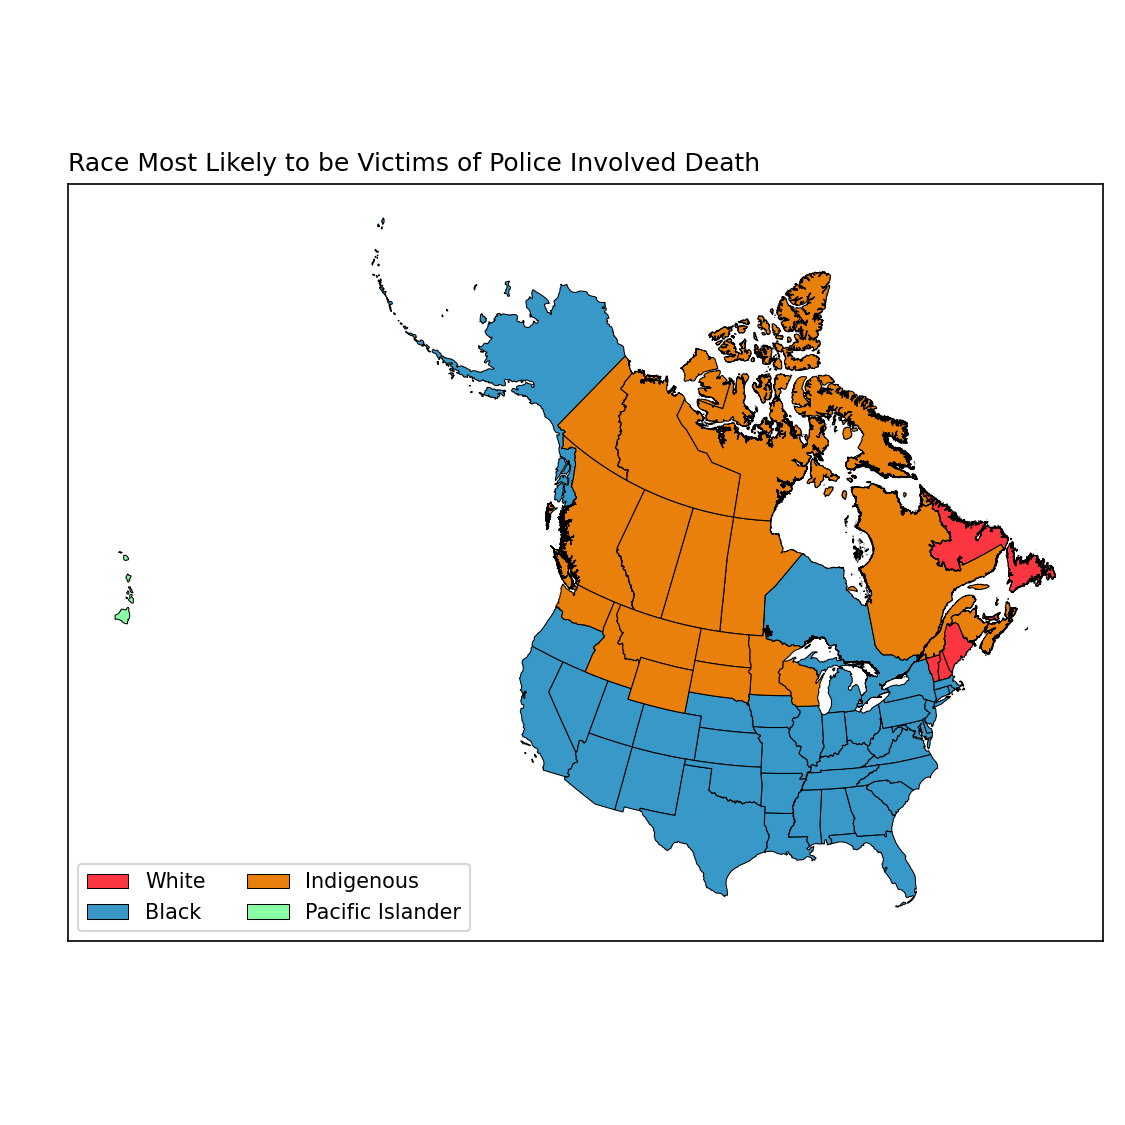

<IPython.core.display.Javascript object>


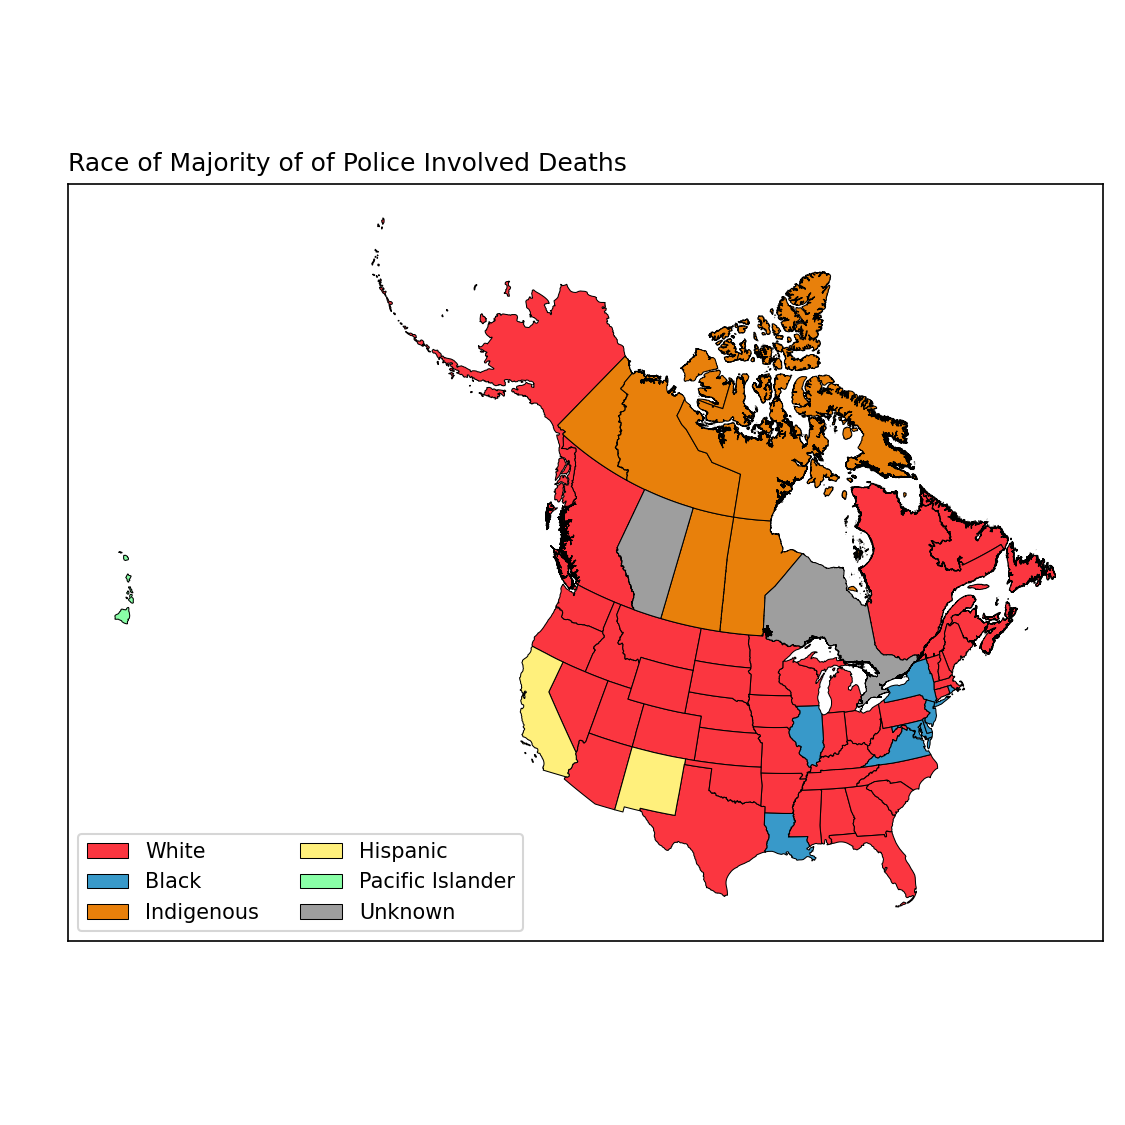

In [24]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',
            'Unknown':'#9e9e9e'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
   #str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Race Most Likely to be Victims of Police Involved Death',loc='left')

plt.savefig('Content/HighestRateRace_Map.png',bbox_inches='tight')

# RaceColor={'White':'#FB3640',
#            'Black':'#3899C9',
#            'Indigenous':'#E8800B',
#            'Hispanic':'#FFF07C',
#            'Pacific Islander':'#89FFA7'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Race of Majority of of Police Involved Deaths',loc='left')

plt.savefig('Content/MostNumerousRace_Map.png',bbox_inches='tight')


https://bccla.org/wp-content/uploads/2012/03/2012-BCCLA-Report-Police-Involved-Deaths3.pdf

['White' 'Unknown' 'Indigenous']
['Black' 'White' 'Hispanic' 'Pacific Islander']


<IPython.core.display.Javascript object>


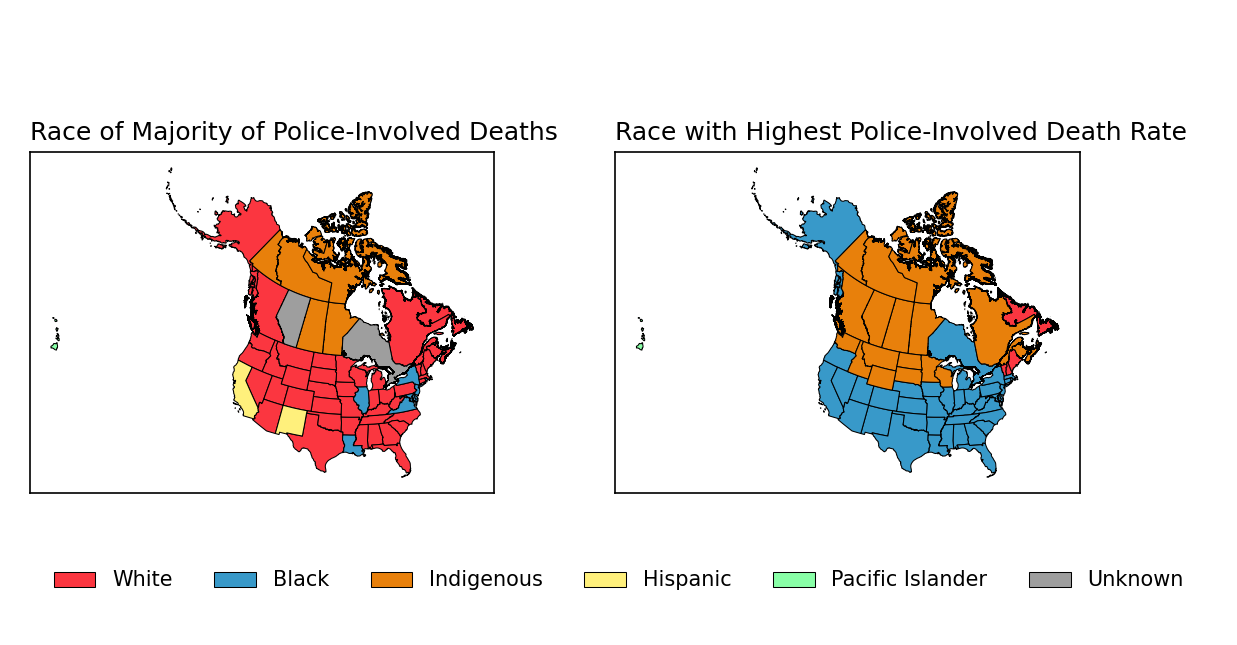

In [25]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',
            'Unknown':'#9e9e9e'}

fig,ax=plt.subplots(1,2,figsize=(8.25,4.3))

CA_Patches = []
for klass in RaceColor.keys():
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax[1],
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))
    
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Race with Highest Police-Involved Death Rate',loc='left')

CA_Patches = []
for klass in RaceColor.keys():
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax[0],
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax[0],
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

# ax[0].legend(handles=(CA_Patches), loc='lower left',ncol=1)
fig.legend(handles=(CA_Patches),loc='center', bbox_to_anchor= (0.5,0.1), ncol=6,
            borderaxespad=0, frameon=False)


    
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Race of Majority of Police-Involved Deaths',loc='left')
plt.tight_layout()

plt.savefig('Content/ImportanceOfNormalizing.png',bbox_inches='tight',dpi=500)
